In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
from scipy import ndimage


from general.readImages import *
from general.readDataFiles import *
from general.saveImages import *
from general.plottingFuncs import *
from segmentation.imageModifiers import *
from segmentation.projEdgeBreaks import *
from segmentation.gaussBreaks import *
from segmentation.gap_metric_breaks import *

mpl.rcParams["figure.figsize"] = (15, 15)
# %matplotlib inline

In [2]:
subjFile = "data_in/anti-slavery-manuscripts-subjects.csv"
subj = pd.read_csv(subjFile)

# get metadata in dictionary format
subj["meta_json"] = [json.loads(q) for q in subj["metadata"]]

# get image url
subj["url"] = [json.loads(q).get("0") for q in subj["locations"]]

# get beta images
subj_beta = subj.loc[subj["subject_set_id"] == 16228]
len(subj_beta)

60

In [3]:
# read in and do all pre-processing #################################
let_orig, grey_orig = readImg(subj_beta["url"].iloc[10])
grey, let, offset = removeEdges(grey_orig, let_orig, 10.0)

Functions for connected component stuff

In [4]:
def boundsAndRecs(labels, osli, buffer = 0):
    rec = []
    bounds = []
    sh = np.max(labels.shape)
    for sl in osli:
        sl0 = sl[0].indices(sh)
        sl1 = sl[1].indices(sh)

        xLeng = sl1[1]-sl1[0]
        yLeng = sl0[1]-sl0[0]
#         if xLeng*yLeng > 100:
        rec.append([[sl1[0], sl0[0]], xLeng, yLeng])
        bounds.append([(sl0[0]-buffer, sl0[1]+buffer),
                       (sl1[0]-buffer, sl1[1]+buffer)])
    return rec, bounds

def plotCC(labels, rec):
    loop = len(labels)
    fig, ax = plt.subplots(figsize=(27, 18), ncols=loop, nrows=1)
    for i in range(loop):
        if loop > 1:
            axf = ax.flatten()[i]
        else:
            axf = ax
        axf.imshow(labels[i], cmap='nipy_spectral')
        for j in range(len(rec[i])):
            rect = mpl.patches.Rectangle(rec[i][j][0], rec[i][j][1], rec[i][j][2],
                                         linewidth=1, edgecolor="r", facecolor="none")
            axf.add_patch(rect)
    plt.show()

# Line breaks

In [5]:
# get linebreaks ####################################################
greySm = smoothImg(grey, 7.0)
matchlim = 30
lb = projBreaks(greySm, "y")
lb = filterBreaks(lb, matchlim)
# plotBoxes(let, lb)#, saveFile="example_img/linebreaks.png")

# Get word breaks via convex hulls

In [6]:
wb = []
for i in range(1, len(lb)):
    chunk = grey[lb[i-1]:lb[i],]
    print(i, end=" ")
    br = gapBreaks(chunk)
    wb.append(br)

1 2 3 4 5 

C:\Users\danny\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\danny\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [9]:
wb2 = []
for l in wb:
    if len(l) > 0:
        wb2.append(l)
    else:
        wb2.append([0])

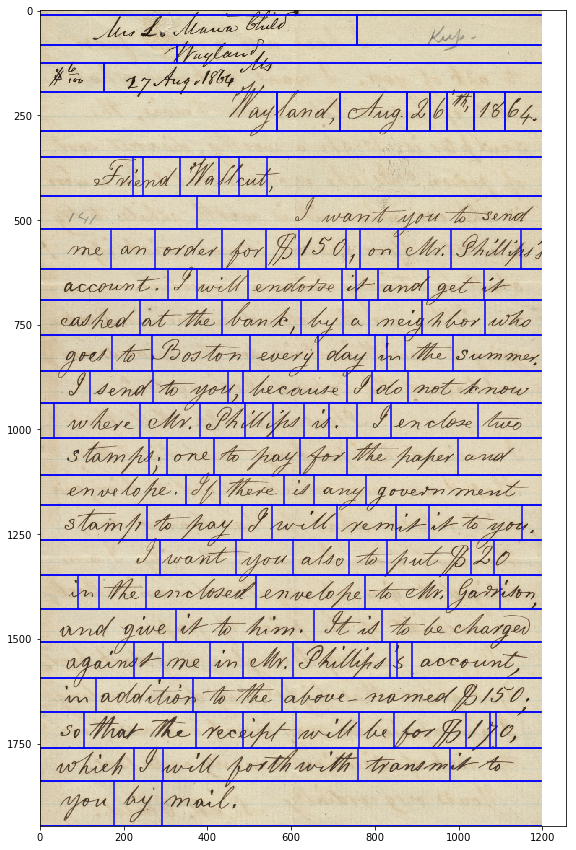

In [10]:
plotBoxes(let, lb, wb2)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

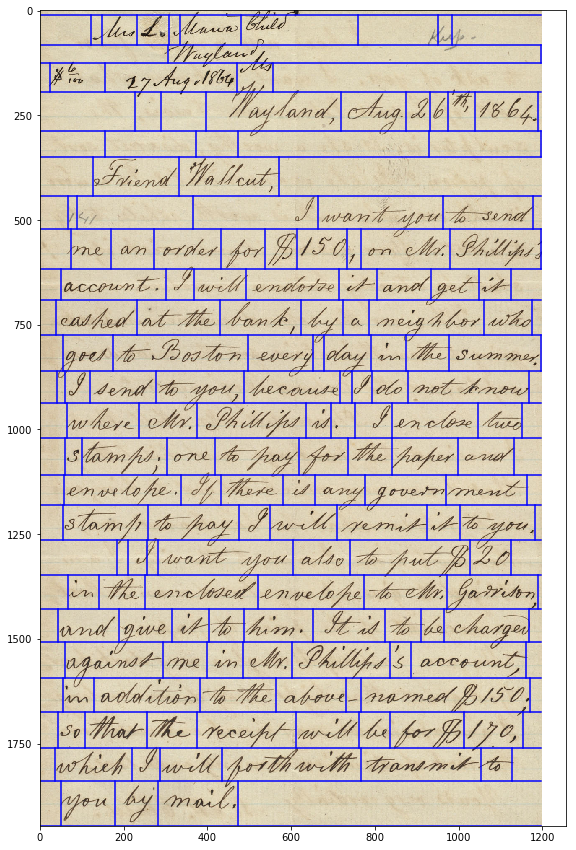

In [11]:
wb3 = []
for i in range(1, len(lb)):
    chunk = grey[lb[i-1]:lb[i],]
    print(i, end=" ")
    br = gaussBreaks(chunk, nu=3.5, biThresh=2.0, shear=0, fix=0,
                     plotIt=False, threshFn=skimfilt.threshold_otsu)
    wb3.append(br)
plotBoxes(let, lb, wb3)